In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from hottbox.utils.generation import residual_tensor
from coursework.data import get_image, plot_tensors

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618077


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create a tensor
I, J, K, L = 2, 3, 5, 7
array_4d = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)
tensor = Tensor(array_4d)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Perform decomposition
# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)
# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(2, 3, 5, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (2, 3, 5, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2, 2)
Mode-1 factor matrix is of shape (3, 3)
Mode-2 factor matrix is of shape (5, 5)
Mode-3 factor matrix is of shape (7, 2)

	Core tensor
This tensor is of order 4 and consists of 60 elements.
Sizes and names of its modes are (2, 3, 5, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [8]:
# Print ratio
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

# Compute no. elements in tensor
tensorElements =  tensor.size
# Compute no. elements in core tensor
coretensorElements = tensor_tkd.core.size
# Compute total no. elements across factor 
factmatElements = 0

for i in range(np.shape(ml_rank)[0]):
    
    factmatElements += (np.shape(tensor_tkd.fmat[i])[0] * np.shape(tensor_tkd.fmat[i])[1])

tuckerElements =  factmatElements + coretensorElements
finalRatio = tensorElements/tuckerElements

print("The ratio between the number of elements of the main tensor and the number of elements of the Tucker representation is {ratio}. ".format(ratio = finalRatio ))
print("This means that the main tensor is compressed by the Tucker form by a factor of {ratio}.".format(ratio = finalRatio))


Relative error of approximation = 0.38871898964218055
The ratio between the number of elements of the main tensor and the number of elements of the Tucker representation is 1.875. 
This means that the main tensor is compressed by the Tucker form by a factor of 1.875.


### Solution: Part 2 - For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?

To deduce the multi-linear rank that would guarantee perfect reconstruction of a 1331-element tensor $\boldsymbol{X}$ from it's Tucker form, we first must consider the potential orders of a tensor with 1331 elements. As per previous work, this is deduced through prime number factorisation; for 1331 this is equal to : $1331 = 11 \cdot 11 \cdot 11$. Hence, the maximum order of a tensor with 1331 elements must be 3. In turn, and as previously evaluated, the order of a tensor should be equal to the order of the core tensor $\boldsymbol{G}$ in Tucker decomposition. This is because Tucker decomposition consists of the core tensor $\boldsymbol{G}$ being multiplied by a factor matrix along each mode. Since the total number of modes (or factor matrices) is equal to the tensor order, it follows that the core tensor must have the same order as the tensor being decomposed.  Taking this order as an example, for perfect reconstruction, it must be true that the rank of each mode subspace of the core tensor must be full-rank i.e. for the main tensor $\boldsymbol{X_{11 \cdot 11 \cdot 11}}$, it's corresponding core tensor $\boldsymbol{G}$ derived from Tucker decomposition must have multi-linear rank $(11,11,11)$ to permit perfect reconstruction. This is because the multi-linear rank of a tensor $\mathbf{{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Using a full-rank for core tensor $\boldsymbol{G}$ means that all dimensions of the subspace are retained, and hence all information across the subspace dimensions is perfectly represented.

Infact, we can go further and conclude that the multi-linear ranking $(11,11,11)$ of the core tensor $\boldsymbol{G}$, in this instance, is the only possible ranking formulation that would guarantee perfect reconstruction of tensor $\boldsymbol{X}$ from it's Tucker form. This is since if we considered the possibility of $\boldsymbol{X}$ having order 2, this would effectively make it a matrix. As noted when order $N > 2$ each rank $R_{n}$ , where $R_{n}$  is the rank of the subspace spanned by mode-n fibres, does not need to equal any other subspace rank. However, for a matrix (when tensor order is 2), the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the ranks of the column and row dimensions of the matrix. There is no integer square root of 1331, only the cubic root, meaning  the condition that $R_1$ and $R_2$ are equal would be violated if the tensor $\boldsymbol{X}$ was order 2. Therefore, we conclude that the multi-linear rank $(11,11,11)$ would enable perfect reconstruction. We can see this in the example coded below.


Although perfect reconstrution is possible, it is not necessarily desirable nor practical. The benefits of Tucker decomposition only arise when not using perfect-reconstruction, as by assigning the ranks $R_{n}$ a value that is not full-rank, the data is approximated and hence compressed into a representation that uses fewer parameters. This in essence is the purpose of the multi-linear rank formulation, to facilitate flexibility in the approximation of the tensor. Consequently, this can help overcome storage issues that might arise with very large tensor datasets e.g. in medical imaging. In particular, approximating the data by performing data compression via Tucker decomposition may enable the use of algorithms to obtain important information from data, that might have otherwise been prohibitive due to high computational costs. Therefore, implementing perfect reconstruction when performing a Tucker decomposition would infact be counterintuitive.

In [9]:
I, J, K = 11, 11,11
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

algorithm = HOOI()
ml_rank = (11, 11, 11)
tensor_tkd = algorithm.decompose(tensor, ml_rank)
print(tensor_tkd)

tensor_res = residual_tensor(tensor, tensor_tkd)
print("Relative error of approximation = {}".format(tensor_res.frob_norm / tensor.frob_norm))
print("Hence, we can see that the reconstruction is practically perfect.")

Tucker representation of a tensor with multi-linear rank=(11, 11, 11).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (11, 11, 11) features respectively.
Relative error of approximation = 1.1800427639380379e-15
Hence, we can see that the reconstruction is practically perfect.


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [10]:
# Create tensors from images
# Get data in form of a Tensor
### CAR ###
car = get_image(item="car", view="top")
tensorCar = Tensor(car)
### APPLE ###
apple =  get_image(item="apple",view="top")
tensorApple = Tensor(apple)

In [11]:
# Perform decomposition
# Initialise algorithm and preform decomposition
###CAR###
algorithm = HOSVD()
tensor_tkdCar = algorithm.decompose(tensorCar, rank=(50, 50, 2))
###APPLE###
algorithm = HOSVD()
tensor_tkdApple = algorithm.decompose(tensorApple, rank=(50, 50, 2))

Relative error of approximation for car = 63.46258384030725
Relative error of approximation for apple = 58.723120440079875


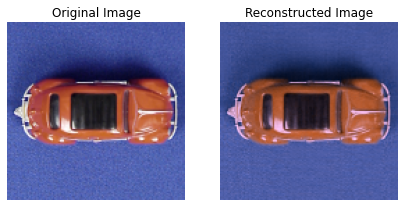

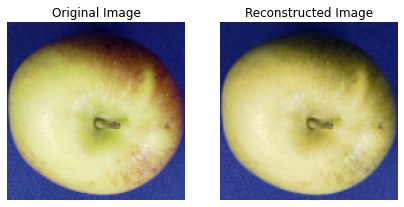

In [12]:
# Evaluate results
###CAR###
tensor_res = residual_tensor(tensorCar, tensor_tkdCar)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation for car = {}".format(rel_error))
# Reconstruction
tensor_recCar = tensor_tkdCar.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensorCar, tensor_recCar)
###APPLE###
tensor_res = residual_tensor(tensorApple, tensor_tkdApple)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation for apple = {}".format(rel_error))
# Reconstruction
tensor_recApple = tensor_tkdApple.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensorApple, tensor_recApple)

By using the operation tensor.shape on the car and apple tensors, we find that the original dimensions of these image tensors was $(128, 128,3)$ meaning that total number of elements after using a multi-linear rank for the core tensor of $(50,50,2)$ reduces from 49152 to 5000. The first two rank values in the multi-linear rank tuple $(R_{1},R_{2},R_{3})$ are used to determine the degree of approximation in the height and width of the image, and the last represents the information about channel i.e. colour. Reducing the total number of elements results in a decrease in image resolution for both the car and apple images - for instance we can see blurring about the edges of the car frame, and about the stalk of the apple.

Reducing the rank value representing channel information from 3 to 2 means that the Tucker decomposition   approximates the colour appearance of the image by selecting the 2 most significant colour representations in the image, and using them as the two degrees of freedom in the approximated representation. Consequently, we see that the apple image suffers more greatly in appearance from this due to significant contributions of blue (background), green (primary apple colour) and red (additional colour on apple surface), whilst the car image only has predominantly red (car paint) and blue (background) colours. For the apple, red shades are primarily removed given that it contributes least to the image, and so the Tucker decomposition removes this 'less valuable' information during the approximation imposed by the multi-linear rank of the core tensor. In constrast, the car image loss green colour information, and consequently, the white elements of the car are turned pink (this is since (normalised) RGB for white is [1 1 1] and pink is [1 0 1] - which is the zeroing of the green channel, although note it is not likely to be such a 'pure' removal of green hue here). Despite this, overall the relative error in approximation for the car image is marginally higher than that of the apple, this is likely since the sharp edges of the car suffer more greatly from the decreased resolution in the Tucker decomposition approximation than the simpler, rounder shape of the apple.



### Solution: Part 2

In [13]:
# Create tensors from images
# Get data in form of a Tensor
### SIDE ###
appleSide = get_image(item="apple", view="side")
tensorSide = Tensor(appleSide)
### TOP ###
appleTop =  get_image(item="apple",view="top")
tensorTop = Tensor(appleTop)

In [14]:
# Perform decomposition
# Initialise algorithm and preform decomposition
###SIDE###
algorithm = HOSVD()
tensor_tkdSide = algorithm.decompose(tensorSide, rank=(50, 50, 2))
###TOP###
algorithm = HOSVD()
tensor_tkdTop = algorithm.decompose(tensorTop, rank=(50, 50, 2))

Relative error of approximation for car = 98.05083951474485
Relative error of approximation for apple = 58.72312044007963


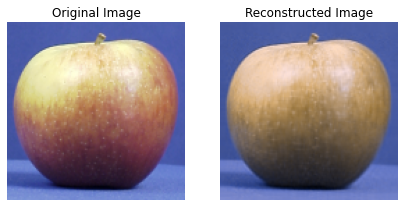

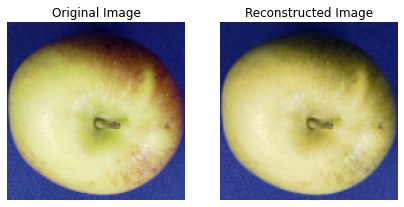

In [15]:
# Evaluate results
###SIDE###
tensor_res = residual_tensor(tensorSide, tensor_tkdSide)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation for car = {}".format(rel_error))
# Reconstruction
tensor_rec = tensor_tkdSide.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensorSide, tensor_rec)
###APPLE###
tensor_res = residual_tensor(tensorTop, tensor_tkdTop)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation for apple = {}".format(rel_error))
# Reconstruction
tensor_rec = tensor_tkdTop.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensorTop, tensor_rec)

When comparing the original images of the apple at the side and at the top, we see that for the side depiction, the red colour is more dominant in the image than green. In constrast, the top of the apple has much more green colour coverage than red. As previously mentioned, reducing the the value of the rank $R_{3}$ in the multi-linear rank representation of the core tensor $\boldsymbol{G}$ from 3 to 2 means that there are now only 2 degrees of freedom/2 dimensions of the subspace spanned by n-mode fibres to represent colour information. Consequently, the Tucker decomposition will choose the two most important colour representations in each viewpoint of the apple, and discard the least significant colour information. Hence in the case of the side view, since green is the least prevalent colour, it is primarily attenuated in the Tucker decomposition approximation, leaving the apple with a brown-red hue. For the top view, it is the red colour that is primarily attenuated, such that the red streaks are replaced with darker green and brown hues. As before, the reduction in ranks $R_{1}$ and $R_{2}$ from 128 to 50 again also adds to the reduction in the resolution in the image, and evidently softens the apple-background boundary.

Finally, we see that the relative error in approximation is significantly greater in the side profile of the apple than the top, and this appears to be since the entire hue of the side profile changes to brown, whilst the original green hue in the green apple remains mostly intact after approximation implemented by Tucker decomposition.

### Solution: Part 3

In [16]:
# Create tensors from images
# Get data in form of a Tensor
### CAR ###
car = get_image(item="car", view="top")
tensorCar = Tensor(car)
### APPLE ###
apple =  get_image(item="apple",view="top")
tensorApple = Tensor(apple)

In [17]:
# Perform decomposition
# Initialise algorithm and preform decomposition
###CAR###
algorithm = HOSVD()
tensor_tkdCar = algorithm.decompose(tensorCar, rank=(50, 50, 1))
###APPLE###
algorithm = HOSVD()
tensor_tkdApple = algorithm.decompose(tensorApple, rank=(50, 50, 1))

Relative error of approximation for car = 323.5024328874227
Relative error of approximation for apple = 265.04542010517923


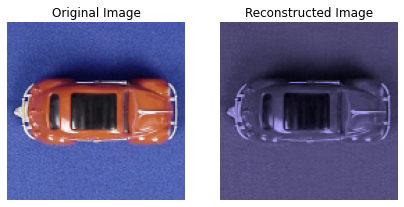

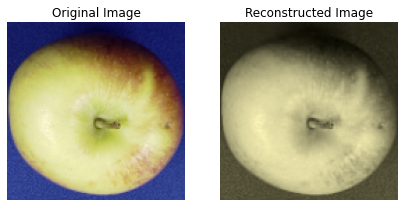

In [18]:
# Evaluate results
# Evaluate results
###CAR###
tensor_res = residual_tensor(tensorCar, tensor_tkdCar)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation for car = {}".format(rel_error))
# Reconstruction
tensor_recCar = tensor_tkdCar.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensorCar, tensor_recCar)
###APPLE###
tensor_res = residual_tensor(tensorApple, tensor_tkdApple)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation for apple = {}".format(rel_error))
# Reconstruction
tensor_recApple = tensor_tkdApple.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(tensorApple, tensor_recApple)

When the rank $R_{3}$ from the multi-linear ranking of the core tensor is reduced from 2 to 1, it leaves only 1 degree of freedom/1 subspace dimension for the representation of colour in the image. With this therefore, the dominant colour hue will be represented on a scale where the value represents the intensity of the colour. For the car image, the predominant colour is blue hence all elements in the image are now represented by an intensity of a blue shade. However for the apple image, given that there is a reasonable balance in the green, blue and red hues , they blend to overall be represented by a monochromatic colour scale (as mixing all shades gives white in RGB space - [1,1,1], and an absence of all shades gives black in RGB - [0,0,0]). There is however a slight tinge of green in the image given its marginal premdominance in representation of the original apple image.

Moreover, given that the total number of elements in the image represenation is now further reduced from 49152 to 2500, there is also a clear additional reduction in the resolution. The combination of lack of colour information, and the blurring of object edges and object-background boundaries corresponds to a significantly greater relative error in approximation for the car compared to apple. This was coded and visualised above to provide clear demonstration of the inituition. 
